In [1]:
# Imports
import math
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

config = {
    'x_low': -4,
    'x_high': 4,
    'encoder_dim': 100,
    'batch_size': 100,
    'latent_dim': 5,
    'intermediate_dim': 10,
    'order': 2,
    'regularization_weight': 1
}

In [2]:
from utils.data_loader import Polyharmonic_Spline_Dataset
from utils.function_families import linear_functions, square_functions, generate_function_family

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

from models.utils import _phi, _pairwise_squared_distance_matrix, _cross_squared_distance_matrix
from models.vae import vae_encoder, vae_decoder

from pivae import piVAE, pivae_loss, pivae_grad

In [4]:
function_families = []

#function_families.extend(generate_function_family(linear_functions))
function_families.extend(generate_function_family(square_functions))

In [5]:
X, Y, S = Polyharmonic_Spline_Dataset(function_families, config)
    
# Define X_
X_ = np.expand_dims(np.expand_dims(np.linspace(-5, 5, 1000), axis=1), axis=0)

In [6]:
function_family_names = [f.__name__ for f in function_families]
function_names = [function_family_names[s] for s in S]

In [7]:
X.shape

(100, 100, 1)

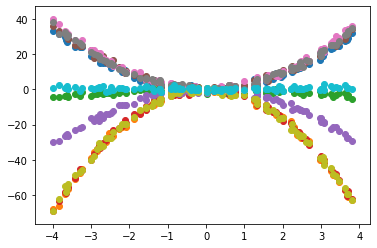

In [8]:
for i in range(10):
    plt.scatter(X[i, :, 0], Y[i, :, 0])

In [9]:
pivae = piVAE(config=config)

linear_basis = pivae.__solve__(X, Y)
Y_ = pivae.__eval__(c=X, linear_basis=linear_basis, q=X_, training=False)

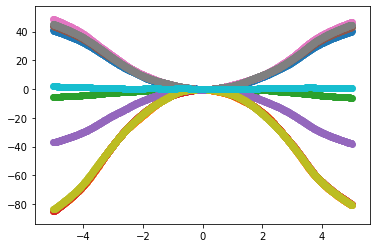

In [10]:
for i in range(10):
    plt.scatter(X_[0, :, 0], Y_[i, :, 0])

In [11]:
dataset = [Polyharmonic_Spline_Dataset(function_families, config)[:2] for i in range(5)]

In [12]:
model = pivae
loss = pivae_loss
grad = pivae_grad

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, decay=0.01, name='Adam'
)

In [13]:
##########################################################################
    
import os
import datetime

# Keep results for plotting
train_loss_results = []

num_epochs = 2000

log_dir = os.path.join(os.path.join(os.getcwd(), "logs"), datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    # Training loop - using batches of 32
    
    for X, Y in dataset:

        y_train, x_train = Y, X

        # Optimize the model
        loss_value, grads = grad(model, x_train, y_train, pivae.trainable_variables)
        optimizer.apply_gradients(zip(grads, pivae.trainable_variables))

        epoch_loss_avg(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result().numpy())

    if epoch % 100 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

    with summary_writer.as_default():
        tf.summary.scalar('epoch_loss_avg', epoch_loss_avg.result(), step=epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 18499852.000
Epoch 100: Loss: 20879.943
Epoch 200: Loss: 15185.011
Epoch 300: Loss: 12296.361
Epoch 400: Loss: 10046.786
Epoch 500: Loss: 8806.556
Epoch 600: Loss: 7619.203
Epoch 700: Loss: 7412.481
Epoch 800: Loss: 6281.731
Epoch 900: Loss: 6949.220
Epoch 1000: Loss: 5448.978
Epoch 1100: Loss: 5340.595
Epoch 1200: Loss: 5266.715
Epoch 1300: Loss: 4818.623
Epoch 1400: Loss: 4788.314
Epoch 1500: Loss: 4136.905
Epoch 1600: Loss: 4012.404
Epoch 1700: Loss: 3967.979
Epoch 1800: Loss: 3579.6

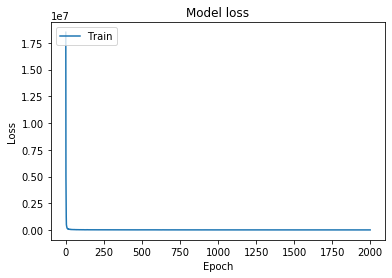

In [14]:
#####################################################################################
    
# Plot training & validation loss values
plt.plot(train_loss_results)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
    
#####################################################################################

In [15]:
lb, lb_reconstruct, z_mean, z_log_var = model.__train__(X, Y)

In [16]:
encoder_weights_mean = pivae.encoder.layers[2](pivae.encoder.layers[1](tf.squeeze(lb, axis=2))).numpy()

In [17]:
import pandas as pd

# Store variables 
encoding = pd.DataFrame(encoder_weights_mean)

In [18]:
encoding.head()

,0,1,2,3,4
0,-6.992912,-8.514320,-0.213301,8.800163,-4.240998
1,-4.392262,-6.903196,-1.197411,5.681115,-4.419474
2,-8.888324,-6.633628,0.417052,8.929160,-7.041754
3,-1.535255,-0.021403,1.982347,-0.464236,0.358754
4,-11.448627,-14.392149,-0.353785,13.032244,-8.160375


In [19]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(encoding.values)

X_embedded = pd.DataFrame(np.dot(encoding.values, pca.components_.T))
X_embedded['function family'] = [l.split('_')[1] for l in function_names]

In [20]:
X_embedded.head()

,0,1,function family
0,13.856197,4.914720,square
1,10.607298,2.503148,square
2,14.298204,6.116993,square
3,-0.538448,2.490771,square
4,22.520153,8.186724,square


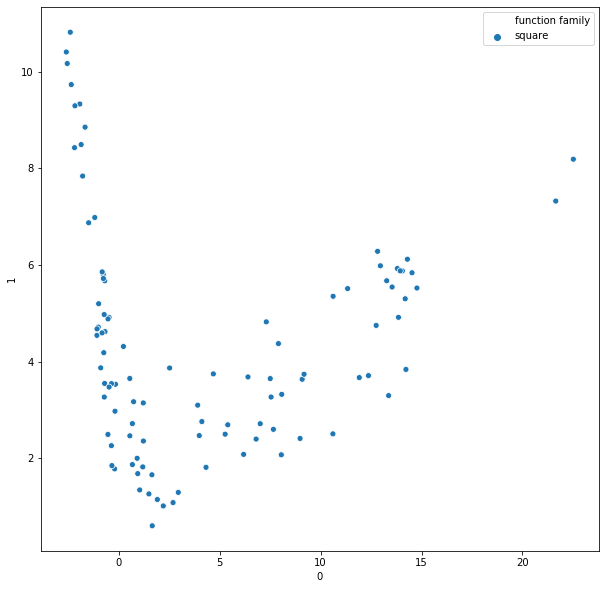

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.scatterplot(x=0, y=1, hue="function family", data=X_embedded)

In [22]:
Y1_ = pivae.__eval__(c=X, linear_basis=lb, q=X_, training=False)
Y2_ = pivae.__eval__(c=X, linear_basis=lb_reconstruct, q=X_, training=False)

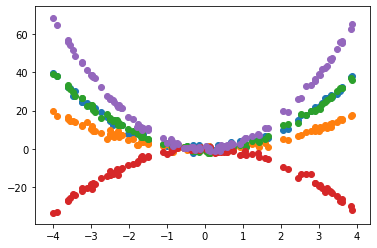

In [23]:
for i in range(5):
    plt.scatter(X[i, :, 0], Y[i, :, 0])

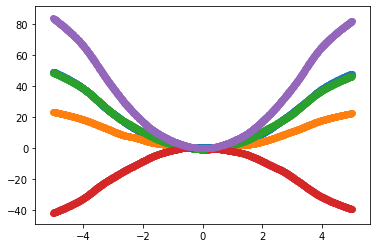

In [24]:
for i in range(5):
    plt.scatter(X_[0, :, 0], Y1_[i, :, 0])

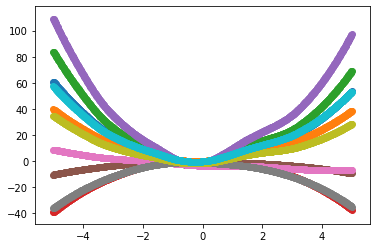

In [25]:
for i in range(10):
    plt.scatter(X_[0, :, 0], Y2_[i, :, 0])